In [1]:
%matplotlib inline
import netCDF4
import rasterio
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'default_rename.set'
argv2 = r'paths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')

In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min
/home/ikeuchi/Share/GLOFRIM/glofrim


## create PCR model BMI object

In [5]:
PCR_config_fn = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')
print(PCR_in_dir)
print(PCR_config_fn)
print(PCR_out_dir)

PCR_bmi = PCR_model(PCR_config_fn, PCR_in_dir, PCR_out_dir,
                            start_date, end_date,)

/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/PCR_Elbe/input30min
/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe.ini
/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/PCR


## create CMF model BMI object

In [6]:
CMF_engine = os.path.join(cwd, options['CMF_engine']['CMF_path'])
print(CMF_engine)
CMF_model_dir = os.path.join(cwd, options['routing_model']['model_dir'])
CMF_config_fn = os.path.join(CMF_model_dir, options['routing_model']['model_file'])
CMF_out_dir = os.path.join(out_dir, 'CMF')
     
CMF_bmi = CMF_model(CMF_engine, CMF_config_fn, CMF_model_dir, CMF_out_dir,
                         start_date, end_date, dt=86400)


2018-02-28 16:33:03,765 - INFO - Loading library from path /home/ikeuchi/Share/GLOFRIM/glofrim/cama-flood_bmi/src/libcama.so


/home/ikeuchi/Share/GLOFRIM/glofrim/cama-flood_bmi/src/libcama.so


## create DFM model BMI object

In [7]:
DFM_engine = os.path.join(cwd, options['DFM_engine']['DFM_path'])
DFM_model_dir = os.path.join(cwd, options['hydrodynamic_model']['model_dir'])
DFM_config_fn = os.path.join(DFM_model_dir, options['hydrodynamic_model']['model_file'])
DFM_out_dir = os.path.join(out_dir, 'DFM')
print(DFM_engine)
print(DFM_model_dir)
print(DFM_config_fn)
print(DFM_out_dir)


DFM_bmi = DFM_model(DFM_engine, DFM_config_fn, DFM_model_dir, DFM_out_dir,
                              start_date, end_date, dt=86400.)

2018-02-28 16:33:03,818 - INFO - Loading library from path /home/ikeuchi/Share/DFLOW-FM/dflowfm-1.1.267/lib/libdflowfm.so


/home/ikeuchi/Share/DFLOW-FM/dflowfm-1.1.267/lib/libdflowfm.so
/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/DFM_Elbe/
/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/DFM_Elbe/Elbe_1way_1d2dFM_400m_3200m.mdu
/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/DFM


## intitialize DFM model

In [8]:
# initialize DFM first to expose model coordinates via BMI
DFM_bmi.initialize()

2018-02-28 16:33:04,056 - INFO - Ini file for DFM written to /home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/DFM/Elbe_1way_1d2dFM_400m_3200m.mdu
2018-02-28 16:33:04,060 - INFO - Loading model /home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/DFM/Elbe_1way_1d2dFM_400m_3200m.mdu in directory /home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/DFM
2018-02-28 16:33:22,818 - INFO - DFM initialized


## couple grids based on CMF inpmat file

In [9]:
# couple grids
PCR_bmi.couple_grid_to_grid(CMF_bmi)

2018-02-28 16:33:22,835 - INFO - Getting PCR model grid parameters.
2018-02-28 16:33:22,850 - INFO - Getting CMF model grid parameters.
2018-02-28 16:33:22,862 - INFO - Coupling PCR grid to CMF grid.
2018-02-28 16:33:22,868 - INFO - ./generate_inpmat 0.5 7.0 17.0 55.0 48.0 NtoS


## couple grids based on 1d DFM indices

Couple external 1d coordinates to internal model 2d grid. 

The model **ldd grid is also deactivated** at coupled cells.

**Note** that this should be excecuted before the CMF model is initalized as the lddl grid modification is done offline!

In [10]:
# get coupled dictionaries
CMF_bmi.couple_grid_to_1d(DFM_bmi)

2018-02-28 16:33:23,055 - INFO - Getting DFM model coordinates.
2018-02-28 16:33:23,121 - INFO - Coupling CMF grid to DFM 1D nodes.
2018-02-28 16:33:23,124 - INFO - Getting CMF model indices for xy coordinates.
2018-02-28 16:33:23,343 - INFO - Getting fraction of coupled 1d nodes based on area.


## initialize CMF and PCR models

In [11]:
# initialize CMF model after nextxy had been adapted
CMF_bmi.initialize()
# initialize model after ldd has been modified
PCR_bmi.initialize()

2018-02-28 16:33:23,386 - INFO - removing tmp file diminfo_tmp.txt from model data dir
2018-02-28 16:33:23,553 - INFO - removing tmp file inpmat-tmp.txt from model data dir
2018-02-28 16:33:23,572 - INFO - removing tmp file inpmat-tmp.bin from model data dir
2018-02-28 16:33:23,599 - INFO - Ini file for CMF written to /home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/CMF/input_flood.nam
2018-02-28 16:33:23,604 - INFO - Loading model /home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/CMF/input_flood.nam in directory /home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/CMF
2018-02-28 16:33:23,647 - INFO - CMF initialized
2018-02-28 16:33:23,674 - INFO - Ini file for PCR written to /home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/PCR/setup_PCR_30min_Elbe.ini
2018-02-28 16:33:23,969 - INFO - Model run started at 2018-02-28 16:33:23.677563
2018-02-28 16:33:23,969 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-02-28 16:33:23.677563
2018-02-28 16:

## define exchange of values in update states function

In [12]:
# determine area fraction for volume distribution
DFMidx = DFM_bmi.coupled_idx
CMFidx = CMF_bmi.coupled_idx
area_all = np.copy(DFM_bmi.get_var('ba'))
area_1d = area_all[DFMidx]

def calc_PCR_volume(runoff):
    cellarea = PCR_bmi.get_var('cellArea')
    cellarea = np.where(np.isnan(cellarea), 0, cellarea)
    PCR_volume = runoff * cellarea
    tot_PCR_volume = np.sum(PCR_volume)
    print 'sum runoff PCR * cellarea PCR: %.3e' % tot_PCR_volume
    return 

def set_CMF_runoff():
    """"
    coupling runoff between CMFan PCR model
    """
    runoff = np.copy(PCR_bmi.get_var('landSurfaceRunoff'))
    runoff = np.where(np.isnan(runoff), 0, runoff)
    calc_PCR_volume(runoff)
    CMF_bmi.set_var("runoff", runoff)
    
def set_DFM_discharge_and_update(updateStep):
    '''
    as the routing is turned off for coupled cells, only local discharge (=runoff) is passed on for coupled cells without an 
    upstream cell
    '''
    
    V_DFM_t0 = np.copy(DFM_bmi.get_var('vol1'))
    print 'V in DFM before adding Q from CMF: %.3e' % np.sum(V_DFM_t0)
    
    discharge_all = np.copy(CMF_bmi.get_var('outflw'))
    discharge = discharge_all[CMFidx] * CMF_bmi.options['dt'] #[m3/dt]
    delta_water_depth_dfm = discharge * CMF_bmi.coupled_area_frac / area_1d # [m/dt]
    DFM_bmi.set_var_index('rain', DFMidx, delta_water_depth_dfm)
    
    discharge = np.where(np.isnan(discharge), 0, discharge)
    tot_Q_CMF2DFM = np.sum(discharge)
    print 'added V from CFM: %.3e' % tot_Q_CMF2DFM
    
    DFM_bmi.update(updateStep)
    
    V_DFM_t1 = np.copy(DFM_bmi.get_var('vol1'))
    print 'V in DFM after adding Q and update: %.3e' % np.sum(V_DFM_t1)
    d_V_DFM = np.sum(V_DFM_t1) - np.sum(V_DFM_t0)
    print 'increase of V DFM: %.3e' % d_V_DFM
    

## run coupled CMF - DFM model
# why is discharge from CMF negative???

In [13]:
updateStep = 86400.

# run coupled model for 2 timesteps
for i in range(20):
    PCR_bmi.update(1)
    set_CMF_runoff()
    CMF_bmi.update()
#    set_DFM_discharge_and_update(updateStep) # kernel dies

2018-02-28 16:33:35,201 - INFO - reading forcings for time 2000-01-01
2018-02-28 16:33:35,201 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
2018-02-28 16:33:35,390 - INFO - updating model to time 2000-01-01
2018-02-28 16:33:35,390 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
2018-02-28 16:33:36,986 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-02-28 16:33:36,986 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-02-28 16:33:37,004 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-02-28 16:33:37,004 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-02-28 16:33:37,012 - INFO - reading forcings for time 2000-01-02
2018-02-28 16:33:37,012 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02


sum runoff PCR * cellarea PCR: 2.313e+07


2018-02-28 16:33:37,217 - INFO - updating model to time 2000-01-02
2018-02-28 16:33:37,217 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-02
2018-02-28 16:33:38,133 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-02, timestep 2
2018-02-28 16:33:38,133 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-02, timestep 2
2018-02-28 16:33:38,163 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-03 00:00:00, timestep 86400.0
2018-02-28 16:33:38,163 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-03 00:00:00, timestep 86400.0
2018-02-28 16:33:38,171 - INFO - reading forcings for time 2000-01-03
2018-02-28 16:33:38,171 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-03


sum runoff PCR * cellarea PCR: 3.024e+07


2018-02-28 16:33:38,371 - INFO - updating model to time 2000-01-03
2018-02-28 16:33:38,371 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-03
2018-02-28 16:33:39,265 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-03, timestep 3
2018-02-28 16:33:39,265 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-03, timestep 3
2018-02-28 16:33:39,299 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-04 00:00:00, timestep 86400.0
2018-02-28 16:33:39,299 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-04 00:00:00, timestep 86400.0
2018-02-28 16:33:39,306 - INFO - reading forcings for time 2000-01-04
2018-02-28 16:33:39,306 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-04


sum runoff PCR * cellarea PCR: 1.024e+07


2018-02-28 16:33:39,514 - INFO - updating model to time 2000-01-04
2018-02-28 16:33:39,514 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-04
2018-02-28 16:33:40,415 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-04, timestep 4
2018-02-28 16:33:40,415 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-04, timestep 4
2018-02-28 16:33:40,451 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-05 00:00:00, timestep 86400.0
2018-02-28 16:33:40,451 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-05 00:00:00, timestep 86400.0
2018-02-28 16:33:40,457 - INFO - reading forcings for time 2000-01-05
2018-02-28 16:33:40,457 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-05


sum runoff PCR * cellarea PCR: 7.619e+07


2018-02-28 16:33:40,665 - INFO - updating model to time 2000-01-05
2018-02-28 16:33:40,665 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-05
2018-02-28 16:33:41,582 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-05, timestep 5
2018-02-28 16:33:41,582 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-05, timestep 5
2018-02-28 16:33:41,620 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-06 00:00:00, timestep 86400.0
2018-02-28 16:33:41,620 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-06 00:00:00, timestep 86400.0
2018-02-28 16:33:41,627 - INFO - reading forcings for time 2000-01-06
2018-02-28 16:33:41,627 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-06


sum runoff PCR * cellarea PCR: 4.219e+07


2018-02-28 16:33:41,831 - INFO - updating model to time 2000-01-06
2018-02-28 16:33:41,831 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-06
2018-02-28 16:33:42,715 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-06, timestep 6
2018-02-28 16:33:42,715 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-06, timestep 6
2018-02-28 16:33:42,752 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-07 00:00:00, timestep 86400.0
2018-02-28 16:33:42,752 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-07 00:00:00, timestep 86400.0
2018-02-28 16:33:42,759 - INFO - reading forcings for time 2000-01-07
2018-02-28 16:33:42,759 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-07


sum runoff PCR * cellarea PCR: 2.431e+06


2018-02-28 16:33:42,968 - INFO - updating model to time 2000-01-07
2018-02-28 16:33:42,968 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-07
2018-02-28 16:33:43,866 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-07, timestep 7
2018-02-28 16:33:43,866 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-07, timestep 7
2018-02-28 16:33:43,899 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-08 00:00:00, timestep 86400.0
2018-02-28 16:33:43,899 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-08 00:00:00, timestep 86400.0
2018-02-28 16:33:43,906 - INFO - reading forcings for time 2000-01-08
2018-02-28 16:33:43,906 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-08


sum runoff PCR * cellarea PCR: 1.083e+07


2018-02-28 16:33:44,110 - INFO - updating model to time 2000-01-08
2018-02-28 16:33:44,110 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-08
2018-02-28 16:33:44,999 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-08, timestep 8
2018-02-28 16:33:44,999 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-08, timestep 8
2018-02-28 16:33:45,033 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-09 00:00:00, timestep 86400.0
2018-02-28 16:33:45,033 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-09 00:00:00, timestep 86400.0
2018-02-28 16:33:45,040 - INFO - reading forcings for time 2000-01-09
2018-02-28 16:33:45,040 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-09


sum runoff PCR * cellarea PCR: 7.034e+06


2018-02-28 16:33:45,245 - INFO - updating model to time 2000-01-09
2018-02-28 16:33:45,245 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-09
2018-02-28 16:33:46,150 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
2018-02-28 16:33:46,150 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
2018-02-28 16:33:46,187 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-10 00:00:00, timestep 86400.0
2018-02-28 16:33:46,187 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-10 00:00:00, timestep 86400.0
2018-02-28 16:33:46,195 - INFO - reading forcings for time 2000-01-10
2018-02-28 16:33:46,195 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-10


sum runoff PCR * cellarea PCR: 3.067e+07


2018-02-28 16:33:46,401 - INFO - updating model to time 2000-01-10
2018-02-28 16:33:46,401 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-10
2018-02-28 16:33:47,275 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-10, timestep 10
2018-02-28 16:33:47,275 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-10, timestep 10
2018-02-28 16:33:47,317 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-11 00:00:00, timestep 86400.0
2018-02-28 16:33:47,317 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-11 00:00:00, timestep 86400.0
2018-02-28 16:33:47,323 - INFO - reading forcings for time 2000-01-11
2018-02-28 16:33:47,323 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-11


sum runoff PCR * cellarea PCR: 2.730e+06


2018-02-28 16:33:47,525 - INFO - updating model to time 2000-01-11
2018-02-28 16:33:47,525 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-11
2018-02-28 16:33:48,403 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
2018-02-28 16:33:48,403 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
2018-02-28 16:33:48,438 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-12 00:00:00, timestep 86400.0
2018-02-28 16:33:48,438 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-12 00:00:00, timestep 86400.0
2018-02-28 16:33:48,445 - INFO - reading forcings for time 2000-01-12
2018-02-28 16:33:48,445 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-12


sum runoff PCR * cellarea PCR: 2.238e+06


2018-02-28 16:33:48,647 - INFO - updating model to time 2000-01-12
2018-02-28 16:33:48,647 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-12
2018-02-28 16:33:49,523 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-12, timestep 12
2018-02-28 16:33:49,523 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-12, timestep 12
2018-02-28 16:33:49,560 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-13 00:00:00, timestep 86400.0
2018-02-28 16:33:49,560 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-13 00:00:00, timestep 86400.0
2018-02-28 16:33:49,566 - INFO - reading forcings for time 2000-01-13
2018-02-28 16:33:49,566 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-13


sum runoff PCR * cellarea PCR: 2.242e+06


2018-02-28 16:33:49,766 - INFO - updating model to time 2000-01-13
2018-02-28 16:33:49,766 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-13
2018-02-28 16:33:50,646 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-13, timestep 13
2018-02-28 16:33:50,646 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-13, timestep 13
2018-02-28 16:33:50,682 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-14 00:00:00, timestep 86400.0
2018-02-28 16:33:50,682 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-14 00:00:00, timestep 86400.0
2018-02-28 16:33:50,689 - INFO - reading forcings for time 2000-01-14
2018-02-28 16:33:50,689 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-14


sum runoff PCR * cellarea PCR: 2.245e+06


2018-02-28 16:33:50,889 - INFO - updating model to time 2000-01-14
2018-02-28 16:33:50,889 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-14
2018-02-28 16:33:51,764 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-14, timestep 14
2018-02-28 16:33:51,764 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-14, timestep 14
2018-02-28 16:33:51,801 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-15 00:00:00, timestep 86400.0
2018-02-28 16:33:51,801 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-15 00:00:00, timestep 86400.0
2018-02-28 16:33:51,808 - INFO - reading forcings for time 2000-01-15
2018-02-28 16:33:51,808 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-15


sum runoff PCR * cellarea PCR: 2.248e+06


2018-02-28 16:33:52,012 - INFO - updating model to time 2000-01-15
2018-02-28 16:33:52,012 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-15
2018-02-28 16:33:52,900 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-15, timestep 15
2018-02-28 16:33:52,900 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-15, timestep 15
2018-02-28 16:33:52,936 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-16 00:00:00, timestep 86400.0
2018-02-28 16:33:52,936 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-16 00:00:00, timestep 86400.0
2018-02-28 16:33:52,943 - INFO - reading forcings for time 2000-01-16
2018-02-28 16:33:52,943 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-16


sum runoff PCR * cellarea PCR: 2.251e+06


2018-02-28 16:33:53,144 - INFO - updating model to time 2000-01-16
2018-02-28 16:33:53,144 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-16
2018-02-28 16:33:54,010 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-16, timestep 16
2018-02-28 16:33:54,010 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-16, timestep 16
2018-02-28 16:33:54,046 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-17 00:00:00, timestep 86400.0
2018-02-28 16:33:54,046 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-17 00:00:00, timestep 86400.0
2018-02-28 16:33:54,053 - INFO - reading forcings for time 2000-01-17
2018-02-28 16:33:54,053 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-17


sum runoff PCR * cellarea PCR: 3.738e+06


2018-02-28 16:33:54,257 - INFO - updating model to time 2000-01-17
2018-02-28 16:33:54,257 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-17
2018-02-28 16:33:55,179 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-17, timestep 17
2018-02-28 16:33:55,179 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-17, timestep 17
2018-02-28 16:33:55,216 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-18 00:00:00, timestep 86400.0
2018-02-28 16:33:55,216 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-18 00:00:00, timestep 86400.0
2018-02-28 16:33:55,224 - INFO - reading forcings for time 2000-01-18
2018-02-28 16:33:55,224 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-18


sum runoff PCR * cellarea PCR: 1.271e+08


2018-02-28 16:33:55,435 - INFO - updating model to time 2000-01-18
2018-02-28 16:33:55,435 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-18
2018-02-28 16:33:56,330 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-18, timestep 18
2018-02-28 16:33:56,330 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-18, timestep 18
2018-02-28 16:33:56,384 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-19 00:00:00, timestep 86400.0
2018-02-28 16:33:56,384 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-19 00:00:00, timestep 86400.0
2018-02-28 16:33:56,393 - INFO - reading forcings for time 2000-01-19
2018-02-28 16:33:56,393 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-19


sum runoff PCR * cellarea PCR: 1.238e+08


2018-02-28 16:33:56,616 - INFO - updating model to time 2000-01-19
2018-02-28 16:33:56,616 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-19
2018-02-28 16:33:57,531 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-19, timestep 19
2018-02-28 16:33:57,531 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-19, timestep 19
2018-02-28 16:33:57,577 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-20 00:00:00, timestep 86400.0
2018-02-28 16:33:57,577 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-20 00:00:00, timestep 86400.0
2018-02-28 16:33:57,584 - INFO - reading forcings for time 2000-01-20
2018-02-28 16:33:57,584 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-20


sum runoff PCR * cellarea PCR: 2.303e+06


2018-02-28 16:33:57,805 - INFO - updating model to time 2000-01-20
2018-02-28 16:33:57,805 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-20
2018-02-28 16:33:58,845 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-20, timestep 20
2018-02-28 16:33:58,845 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-20, timestep 20
2018-02-28 16:33:58,885 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-21 00:00:00, timestep 86400.0
2018-02-28 16:33:58,885 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-21 00:00:00, timestep 86400.0


sum runoff PCR * cellarea PCR: 3.528e+07


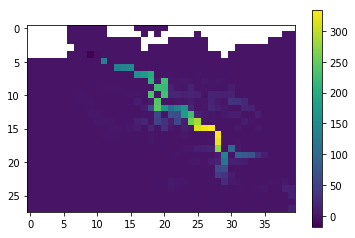

In [14]:
import matplotlib.pyplot as plt
outflw = np.copy(CMF_bmi.get_var('outflw'))
#outflw = np.copy(PCR_bmi.get_var('landSurfaceRunoff'))

plt.imshow(outflw)
plt.colorbar()

In [15]:
# no clue what q1 is and why it has much more entries than total cells in DFM model... ask Arthur?
q1 = np.copy(DFM_bmi.get_var('q1'))
print len(q1), len(area_all)

98312 53638


In [16]:
# there is a variable qtotal_1d2d but it returns a NULL pointer for me... different for you?
DFM_bmi.get_var('qtotal_1d2d')

2018-02-28 16:33:59,218 - INFO - NULL pointer returned
2018-02-28 16:33:59,218 bmi.wrapper INFO NULL pointer returned


array(None, dtype=object)

## Finalize models

In [17]:
PCR_bmi.finalize()
CMF_bmi.finalize()
DFM_bmi.finalize()


2018-02-28 16:33:59,244 - INFO - cd /home/ikeuchi/Share/GLOFRIM/glofrim
2018-02-28 16:33:59,244 bmi.wrapper INFO cd /home/ikeuchi/Share/GLOFRIM/glofrim
2018-02-28 16:33:59,256 - INFO - cd /home/ikeuchi/Share/GLOFRIM/glofrim
2018-02-28 16:33:59,256 bmi.wrapper INFO cd /home/ikeuchi/Share/GLOFRIM/glofrim
